# diagnoses_icd

In [1]:
import pandas as pd

In [2]:
diagnoses = pd.read_csv('/data/share/AKI/3.0/hosp/diagnoses_icd.csv.gz', compression = 'gzip')

In [3]:
diagnoses.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')

In [4]:
print(diagnoses.head(10))
print('-----------------')
print(diagnoses.shape)

   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9
5    10000032  22595853        6    29680            9
6    10000032  22595853        7    30981            9
7    10000032  22595853        8    V1582            9
8    10000032  22841357        1    07071            9
9    10000032  22841357        2    78959            9
-----------------
(6364520, 5)


In [5]:
target_value = ['5845', '5846', '5847', '5848', '5849', '66930', '66932', '66934', 'N17', 'N170', 'N171', 'N172', 'N178', 'N179', 'Q904']

In [6]:
diagnoses = diagnoses.drop(['seq_num', 'icd_version'], axis = 1)

In [7]:
diagnoses['target'] = diagnoses['icd_code'].apply(lambda x : 1 if x in target_value else 0)
diagnoses['target'].value_counts() 
"""
without AKI 0.99
with AKI 0.01
"""

'\nwithout AKI 0.99\nwith AKI 0.01\n'

In [8]:
aki_list = diagnoses[diagnoses['target'] == 1]['hadm_id'].unique()
not_aki_list = diagnoses[diagnoses['target'] == 0]['hadm_id'].unique()

# Inputevents

In [9]:
import gc
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

icu_path = '/data/share/AKI/3.0/icu/'
label_data = pd.read_csv('/home/stateun/aki_hadm.csv')

label_subject = label_data['subject_id']
label_hadm = label_data['hadm_id']
label_aki = label_data['aki']

In [10]:
inputevents = pd.read_csv('/data/share/AKI/3.0/icu/inputevents.csv.gz', compression = 'gzip')

In [11]:
inputevents.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate'],
      dtype='object')

In [24]:
inputevents = inputevents.drop(['stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime','amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate'], axis= 1)

AttributeError: 'TextFileReader' object has no attribute 'drop'

In [12]:
# Check the nan value
sum(inputevents['amount'].isna())

0

In [13]:
inputevents['amount'].dtypes

dtype('float64')

In [14]:
"""
Check the Outlier
"""

def compute_stats(group):
    min_val = group.min()
    max_val = group.max()
    mean = group.mean()
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return pd.Series({'min': min_val, 'max': max_val,'mean' : mean, 'Q1-1.5*IQR' : lower_fence ,'Q3+1.5*IQR': upper_fence})

stats = inputevents.groupby('itemid')['amount'].apply(compute_stats).unstack().reset_index()
stats.head(20)

,itemid,min,max,mean,Q1-1.5*IQR,Q3+1.5*IQR
0,220862,0.222346,999.999976,73.122153,-24.999999,174.999996
1,220864,2.083333,1499.999943,338.729269,-124.999995,874.999967
2,220949,-8.242694,100500.000000,110.863365,-186.823626,356.441368
3,220950,0.083333,1999.999952,342.049966,-615.522533,1219.313520
4,220952,0.000000,240.000000,32.547609,-12.500000,87.500000
5,220970,0.136187,13800.000000,294.980042,227.499976,367.500014
6,220995,0.037500,7545.778503,101.987106,-109.687500,305.812500
7,221036,0.100004,4999.999924,323.892943,-428.970757,1003.047835
8,221207,0.583440,2600.000000,369.492998,-494.333495,1096.507992
9,221261,0.429139,7.494624,5.201391,-0.141747,11.363121


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7f858fc1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7f858fc700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7f858eaee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7f858fcc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7f858fcee0>],
 'means': []}

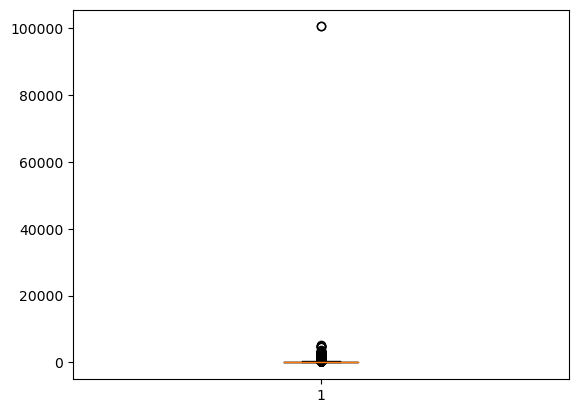

In [16]:
plt.boxplot(inputevents[(inputevents['itemid'] == 220949)]['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7f84e7cc40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7f84e8d1c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7f84e7c9a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7f84e8d700>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7f84e8d9a0>],
 'means': []}

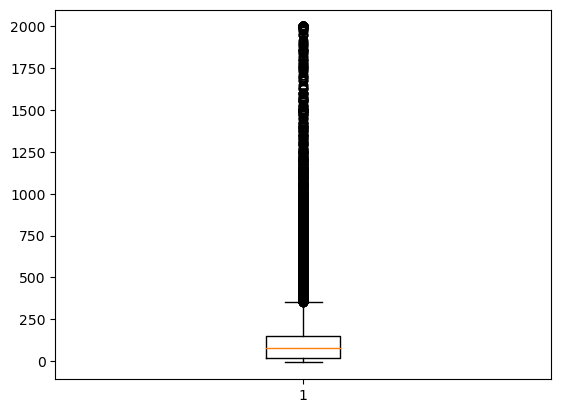

In [22]:
plt.boxplot(inputevents[(inputevents['itemid'] ==  220949) & (inputevents['amount'] < 2000)]['amount'])

In [23]:
"""
Remove the Outlier
"""

inputevents = pd.read_csv(icu_path + 'inputevents.csv.gz', compression='gzip', chunksize=10**6)

for i, chunk in enumerate(tqdm(inputevents, desc='Processing chunks')):

    chunk = chunk.merge(stats[['itemid', 'Q1-1.5*IQR', 'Q3+1.5*IQR']], on='itemid', how='left')
    chunk.head(5)

    chunk.dropna(subset=['Q1-1.5*IQR', 'Q3+1.5*IQR'], inplace=True)

    mask = (chunk['amount'] >= chunk['Q1-1.5*IQR']) & (chunk['amount'] <= chunk['Q3+1.5*IQR'])
    chunk = chunk[mask]

    chunk.drop(['Q1-1.5*IQR', 'Q3+1.5*IQR'], axis=1, inplace=True)

    chunk.to_csv(f'preprocessing_inputevents_{i}.csv', index=False)
    
    print(f'{i}-th preprocessing complete.')

    del chunk
    gc.collect()

Processing chunks: 0it [00:00, ?it/s]

0-th preprocessing complete.


Processing chunks: 1it [00:15, 15.70s/it]

1-th preprocessing complete.


Processing chunks: 3it [00:48, 16.31s/it]

2-th preprocessing complete.


Processing chunks: 4it [01:04, 16.01s/it]

3-th preprocessing complete.


Processing chunks: 5it [01:20, 15.98s/it]

4-th preprocessing complete.


Processing chunks: 6it [01:35, 15.69s/it]

5-th preprocessing complete.


Processing chunks: 7it [01:50, 15.43s/it]

6-th preprocessing complete.


Processing chunks: 8it [02:05, 15.26s/it]

7-th preprocessing complete.


Processing chunks: 9it [02:20, 15.21s/it]

8-th preprocessing complete.


Processing chunks: 10it [02:34, 15.05s/it]

9-th preprocessing complete.


Processing chunks: 11it [02:48, 15.35s/it]

10-th preprocessing complete.


In [25]:
stats.head(5)

,itemid,min,max,mean,Q1-1.5*IQR,Q3+1.5*IQR
0,220862,0.222346,999.999976,73.122153,-24.999999,174.999996
1,220864,2.083333,1499.999943,338.729269,-124.999995,874.999967
2,220949,-8.242694,100500.000000,110.863365,-186.823626,356.441368
3,220950,0.083333,1999.999952,342.049966,-615.522533,1219.313520
4,220952,0.000000,240.000000,32.547609,-12.500000,87.500000


In [26]:
file_path = '/home/stateun/'
output_file = '/home/stateun/inputevents.csv'

for i in range(0,10):
    file_name = f'preprocessing_inputevents_{i}.csv'
    full_path = os.path.join(file_path, file_name)
    
    chunk = pd.read_csv(full_path)
    if i == 1:
        chunk.to_csv(output_file, mode='w', index=False)
    else:
        chunk.to_csv(output_file, mode='a', index=False, header=False)
        
    print(f'{i+1}/{10}번째 파일 처리 완료: {file_name}')
    
    try :
        os.remove(full_path)
    except Exception as e:
        print(f'{file_name} 파일 삭제 중 오류 발생 : {e}')
    
print('모든 파일이 성공적으로 병합되었습니다.')

1/10번째 파일 처리 완료: preprocessing_inputevents_0.csv
2/10번째 파일 처리 완료: preprocessing_inputevents_1.csv
3/10번째 파일 처리 완료: preprocessing_inputevents_2.csv
4/10번째 파일 처리 완료: preprocessing_inputevents_3.csv
5/10번째 파일 처리 완료: preprocessing_inputevents_4.csv
6/10번째 파일 처리 완료: preprocessing_inputevents_5.csv
7/10번째 파일 처리 완료: preprocessing_inputevents_6.csv
8/10번째 파일 처리 완료: preprocessing_inputevents_7.csv
9/10번째 파일 처리 완료: preprocessing_inputevents_8.csv
10/10번째 파일 처리 완료: preprocessing_inputevents_9.csv
모든 파일이 성공적으로 병합되었습니다.


In [27]:
inputevents = pd.read_csv('/home/stateun/inputevents.csv')

In [28]:
aki_hadms = inputevents.loc[inputevents['hadm_id'].isin(aki_list)]['hadm_id'].unique().tolist()

In [29]:
hadm_ids = inputevents.hadm_id.unique().tolist()
aki_hadms_set = set(aki_hadms)
hadm_aki_dict = {'hadm_id' : hadm_ids, 'aki':[int(h in aki_hadms_set) for h in hadm_ids]}
hadm_aki_df = pd.DataFrame(hadm_aki_dict)

In [30]:
# 1
inputevents['aki'] = inputevents['hadm_id'].apply(lambda x : 1 if  x in aki_list else 0)

In [293]:
# 2
inputevents['aki'] = inputevents['hadm_id'].isin(aki_list).astype(int)

In [31]:
inputevents_icd = inputevents[['subject_id', 'hadm_id']].drop_duplicates()
hadm_to_subject = {str(h):s for s, h in zip(inputevents_icd.subject_id.tolist(), inputevents_icd.hadm_id.tolist())}
aki_subject = [s for h, s in hadm_to_subject.items() if int(h) in aki_hadms_set]

In [32]:
# Simple code
aki_subject = inputevents[inputevents['hadm_id'].isin(aki_list)]['subject_id'].tolist()

In [33]:
aki_subject_set = set(aki_subject)

In [34]:
aki_first_prev_hadm = []
aki_last_prev_hadm = []
aki_subject_for_check = []
for key, df in tqdm(inputevents_icd.groupby(by = ['subject_id'])):
    had_aki = list(set(df.hadm_id).intersection(aki_hadms_set))
    if had_aki:
        first_h = np.array(had_aki).min()
        last_h = np.array(had_aki).max()
        first_prev_h = df.loc[df.hadm_id <= first_h, 'hadm_id'].tolist()
        last_prev_h = df.loc[df.hadm_id <= last_h, 'hadm_id'].tolist()
        aki_first_prev_hadm.extend(first_prev_h)
        aki_last_prev_hadm.append(last_prev_h)
        aki_subject_for_check.append(key)

  0%|          | 0/48367 [00:00<?, ?it/s]/usr/local/anaconda3/envs/latest/lib/python3.9/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 48367/48367 [00:10<00:00, 4568.59it/s]


In [35]:
from statsmodels.stats.proportion import proportions_ztest

In [36]:
def do_everything3(df, colname, val_colname):
    # Exclude rows where 'hadm_id' is null
    df = df.loc[~df['hadm_id'].isnull(), :]

    # Create 'is_aki' column to identify AKI subjects
    df['is_aki'] = df['subject_id'].isin(aki_subject_set)

    # Calculate the number of unique hadm_ids
    n_hadms = df['hadm_id'].nunique()
    n_aki_hadms = df.loc[df['is_aki'], 'hadm_id'].nunique()
    print(f'# unique aki hadms : {n_aki_hadms}\n# unique hadms : {n_hadms}')

    # Get unique combinations of 'hadm_id' and 'colname'
    colname_hadm = df[['hadm_id', colname]].drop_duplicates()
    colname_aki_hadm = df.loc[df['is_aki'], ['hadm_id', colname]].drop_duplicates()

    # Compute counts of hadm_ids per colname
    colname_hadm_counts = colname_hadm.groupby(colname)['hadm_id'].count()
    colname_aki_hadm_counts = colname_aki_hadm.groupby(colname)['hadm_id'].count()

    # Align indices
    colname_all = colname_hadm_counts.index.union(colname_aki_hadm_counts.index)
    colname_hadm_counts = colname_hadm_counts.reindex(colname_all, fill_value=0)
    colname_aki_hadm_counts = colname_aki_hadm_counts.reindex(colname_all, fill_value=0)

    # Perform z-test for proportions
    code_test_pval = {}
    print(f'Calculating p-values for every code...')
    for k in tqdm(colname_all):
        counts = np.array([colname_aki_hadm_counts[k], colname_hadm_counts[k] - colname_aki_hadm_counts[k]])
        nobs = np.array([n_aki_hadms, n_hadms - n_aki_hadms])

        if 0 not in nobs:
            if 0 not in counts:
                stat, pval = proportions_ztest(counts, nobs)
                code_test_pval[k] = pval
            elif counts[1] == 0:
                code_test_pval[k] = 0
            else:
                print(f'Code {k} has 0 counts in AKI... wrong counting')
        else:
            print(f'Zero in nobs for code {k}')

    aki_code_top = {k for k, v in code_test_pval.items() if v < 0.05}
    print(f'There are {len(aki_code_top)} codes with p-value < 0.05.')

    # Select codes with counts greater than the mean
    code_top = colname_hadm_counts[colname_hadm_counts > colname_hadm_counts.mean()].index
    print(f'# codes with count larger than mean: {len(code_top)}')

    # Intersection of codes with p-value < 0.05 and counts > mean
    final_aki_code_top = aki_code_top.intersection(code_top)
    print(f'Finally, we got {len(final_aki_code_top)} codes to maintain.')

    fact = list(final_aki_code_top)

    # Create a new dataframe using pivot
    print('\nCreating new dataframe...')
    df_filtered = df[df[colname].isin(fact)]
    grouped = df_filtered.groupby(['subject_id', 'hadm_id', colname])[val_colname].mean().reset_index()
    pivot_df = grouped.pivot(index=['subject_id', 'hadm_id'], columns=colname, values=val_colname).reset_index()
    pivot_df = pivot_df.fillna(0)

    # Prompt for column name prefix
    prefix = input('Column name prefix: ')

    # Rename columns
    new_colnames = ['value_' + prefix + '_' + str(c) for c in pivot_df.columns if c not in ['subject_id', 'hadm_id']]
    pivot_df.columns = ['subject_id', 'hadm_id'] + new_colnames

    final_df = pivot_df

    return final_aki_code_top, final_df

In [37]:
inputevents.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate', 'aki'],
      dtype='object')

In [39]:
inputevents = inputevents.drop(['stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime','amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate'], axis= 1)

In [40]:
inputevents.columns

Index(['subject_id', 'hadm_id', 'itemid', 'amount', 'aki'], dtype='object')

In [42]:
list, data = do_everything3(inputevents, 'itemid', 'amount')

# unique aki hadms : 24557
# unique hadms : 63175
Calculating p-values for every code...


100%|██████████| 326/326 [00:00<00:00, 6359.50it/s]

Code 225993 has 0 counts in AKI... wrong counting
Code 226020 has 0 counts in AKI... wrong counting
Code 226044 has 0 counts in AKI... wrong counting
Code 227977 has 0 counts in AKI... wrong counting
Code 228355 has 0 counts in AKI... wrong counting
Code 228356 has 0 counts in AKI... wrong counting
Code 228360 has 0 counts in AKI... wrong counting
Code 228361 has 0 counts in AKI... wrong counting
There are 248 codes with p-value < 0.05.
# codes with count larger than mean: 68
Finally, we got 64 codes to maintain.

Creating new dataframe...


In [43]:
data.to_csv('final_inputevents.csv', index = False)

os.remove('inputevents.csv')